<a href="https://colab.research.google.com/github/guru3/soduku_solver/blob/master/Initial%20analysis%20-%20Can%20deep%20learning%20solve%20soduku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Can a neural network learn to solve the soduku game? 
#### We take the dataset from kaggle : https://www.kaggle.com/bryanpark/sudoku

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"guru333","key":"695a60acdd9541c267fbd36712d5ffcd"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download bryanpark/sudoku
!unzip sudoku.zip

 72% 49.0M/68.1M [00:01<00:00, 33.8MB/s]
100% 68.1M/68.1M [00:01<00:00, 61.2MB/s]
Archive:  sudoku.zip
  inflating: sudoku.csv              


In [3]:
import csv
import pickle
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Conv2D,Dense,Flatten,Input
import matplotlib.pyplot as plt
from keras.utils import to_categorical

Using TensorFlow backend.


#### Let's take a look at the data first

In [0]:
def read_raw_data(total_to_read):
    FILE_PATH = './sudoku.csv';
    soduku_games = csv.reader(open(FILE_PATH,'r'))
    next(soduku_games);

    quizzes = [];
    solutions = [];
    index = 0;
    for game in soduku_games:
        index = index+ 1;
        if( index == total_to_read ):
            break;
        
        quizzes.append( np.reshape([int(d) for d in game[0]], (9, 9)) )
        solutions.append( np.reshape([int(d) for d in game[1]], (9, 9)) )
        
    permutation = np.random.permutation(len(quizzes));
    quizzes = np.array(quizzes)[permutation];
    solutions = np.array(solutions)[permutation];
    return quizzes, solutions;

In [0]:
X, Y = read_raw_data(100);

In [8]:
print('Single training input shape',X.shape[1:])
print('Single training output shape',Y.shape[1:])
print('Sample unsolved sudoku:\n',X[0])
print('Sample solved sudoku:\n', np.reshape(Y[0],(9,9)))

Single training input shape (9, 9)
Single training output shape (9, 9)
Sample unsolved sudoku:
 [[2 0 6 0 3 0 0 0 0]
 [0 0 1 0 6 5 0 7 0]
 [0 4 7 1 0 8 0 5 0]
 [5 0 0 0 0 0 0 2 9]
 [0 0 8 0 1 9 4 0 6]
 [0 0 0 4 2 0 0 0 1]
 [0 0 0 0 4 2 8 0 0]
 [6 0 9 3 0 0 0 0 5]
 [0 7 0 0 0 0 0 1 3]]
Sample solved sudoku:
 [[2 5 6 7 3 4 1 9 8]
 [8 9 1 2 6 5 3 7 4]
 [3 4 7 1 9 8 6 5 2]
 [5 1 4 6 8 3 7 2 9]
 [7 2 8 5 1 9 4 3 6]
 [9 6 3 4 2 7 5 8 1]
 [1 3 5 9 4 2 8 6 7]
 [6 8 9 3 7 1 2 4 5]
 [4 7 2 8 5 6 9 1 3]]


In [0]:
unsolved_cells = []
for unsolved in X:
    count = 0;
    for row in unsolved:
        for cell in row:
            if cell == 0: #unsolved!
                count = count + 1;
    unsolved_cells.append( count );

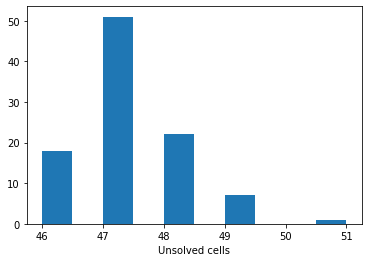

In [10]:
plt.xlabel("Unsolved cells")
_ = plt.hist(unsolved_cells, bins=10);

### Hmm there isn't much difficult level variation. We can try manually increased the cells that are unsolved while maintaining the given clue count above or equal to 17 ( https://www.technologyreview.com/2012/01/06/188520/mathematicians-solve-minimum-sudoku-problem/ )
#### For now, let's write initial model and try to get some decent accuracy, then we will try to improve the model

In [0]:
def change_output(Y):
    return [ Y[:,i,j,:] for i in range(9) for j in range(9) ]
    
def data_to_categorical(): # we will use one hot encoding of input and output  - this breakdown is more intuitive in the given case of discrete numbers
    X, Y = read_raw_data(50000);
    
    X = to_categorical(X, num_classes=10)
    Y = to_categorical(Y-1, num_classes=9)
    total_ex = X.shape[0];
    training_ex = (int)(total_ex*0.8);
    validation_ex= (int)(total_ex*0.1);
    train_X, train_Y = X[:training_ex], change_output(Y[:training_ex]);
    valid_X, valid_Y = X[training_ex:training_ex+validation_ex], change_output(Y[training_ex:training_ex+validation_ex]);
    test_X, test_Y = X[training_ex+validation_ex:], change_output(Y[training_ex+validation_ex:]);
    
    return train_X, train_Y, valid_X, valid_Y, test_X, test_Y;

In [0]:
train_X,train_Y,valid_X,valid_Y,test_X,test_Y = data_to_categorical();

In [27]:
print(train_X.shape)
print(len(train_Y),train_Y[0].shape)

(39999, 9, 9, 10)
81 (39999, 9)


In [0]:
def get_model():
    model = Sequential();
    model.add( Dense(64, input_shape=(9,9,10)) );
    model.add( Dense(32) );
    model.add( Flatten() )
    
    input_ = Input(shape=(9,9,10))
    intermediate_output = model(input_)
    
    outputs = [ Dense(9, activation='sigmoid')(intermediate_output) for i in range(81) ] #for each cell in sudoku table
    model = Model(input_, outputs);
    model.compile( optimizer='AdaDelta', loss='categorical_crossentropy', metrics= ['accuracy'] )
    return model

In [0]:
model = get_model();

In [30]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 9, 9, 10)     0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 2592)         2784        input_3[0][0]                    
__________________________________________________________________________________________________
dense_168 (Dense)               (None, 9)            23337       sequential_3[1][0]               
__________________________________________________________________________________________________
dense_169 (Dense)               (None, 9)            23337       sequential_3[1][0]               
____________________________________________________________________________________________

In [31]:
history = model.fit(train_X, train_Y, epochs=20, validation_data=(valid_X, valid_Y))

Train on 39999 samples, validate on 4999 samples
Epoch 1/20
39999/39999 [==============================] - 156s 4ms/step - loss: 60.4268 - dense_168_loss: 0.7535 - dense_169_loss: 0.7440 - dense_170_loss: 0.7544 - dense_171_loss: 0.7383 - dense_172_loss: 0.7435 - dense_173_loss: 0.7461 - dense_174_loss: 0.7456 - dense_175_loss: 0.7434 - dense_176_loss: 0.7435 - dense_177_loss: 0.7420 - dense_178_loss: 0.7472 - dense_179_loss: 0.7402 - dense_180_loss: 0.7535 - dense_181_loss: 0.7568 - dense_182_loss: 0.7599 - dense_183_loss: 0.7399 - dense_184_loss: 0.7419 - dense_185_loss: 0.7465 - dense_186_loss: 0.7451 - dense_187_loss: 0.7372 - dense_188_loss: 0.7361 - dense_189_loss: 0.7395 - dense_190_loss: 0.7344 - dense_191_loss: 0.7414 - dense_192_loss: 0.7495 - dense_193_loss: 0.7551 - dense_194_loss: 0.7489 - dense_195_loss: 0.7567 - dense_196_loss: 0.7612 - dense_197_loss: 0.7548 - dense_198_loss: 0.7387 - dense_199_loss: 0.7458 - dense_200_loss: 0.7399 - dense_201_loss: 0.7338 - dense_202_l

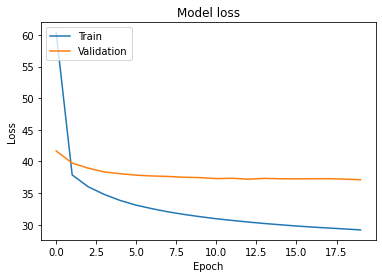

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Okay we have got something! Now it's time to fine tune the model. Also we have complete solution already...in next iteration let's train with complete solution, then try adding more unallocated cells in the sudoku table, and train further!